## Mutual Information on VGG

Código implementado para realizar las estimaciones de información mutua en la base de datos CIFAR10 utilizando la red VGG entrenada

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image

import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
import time
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression as mutual_inf
from sklearn.feature_selection import mutual_info_classif as mutual_int

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
class EncoderVGG16(nn.Module):
    def __init__(self,
                 n_layers = 5,
                 h_dims = [512,256,128,10]):

        super(EncoderVGG16,self).__init__()
        self.n_layers = n_layers
        self.h_dims = h_dims
        self.layers = [5,10,17,24,31]
        self.full_vgg16 = torchvision.models.vgg16()
        self.vgg = self.full_vgg16.features[:self.layers[self.n_layers-1]]

        self.classifier = self.full_vgg16.classifier


        self.classifier[0] = nn.Linear(self.h_dims[0], self.h_dims[1])
        self.classifier[3] = nn.Linear(self.h_dims[1], self.h_dims[2])
        self.classifier[6] = nn.Linear(self.h_dims[2], self.h_dims[3])


    def encode(self,x, layer = 5):
        return self.vgg[:self.layers[layer-1]](x)

    def forward(self,x):
        latent = self.encode(x)
        latent = torch.flatten(latent,start_dim = 1)
        output = self.classifier(latent)

        return output

In [ ]:
if not os.path.exists("data"):
    os.makedirs("data")
    print("Data directory created :D")

if not os.path.exists("data/train"):
    os.makedirs("data/train")
    print("Data train directory created :D")

if not os.path.exists("data/val"):
    os.makedirs("data/val")
    print("Data val directory created :D")

Data directory created :D
Data train directory created :D
Data val directory created :D


In [ ]:
transform = transforms.Compose([
     transforms.ToTensor(),
    #  transforms.Lambda(gaussian_pixels),
    # transforms.Normalize(mean=[0.49139968, 0.48215827 ,0.44653124],std=[0.24703233, 0.24348505, 0.26158768]),
     ])

tensor = transforms.ToTensor()

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root = "data/train/",train=True, transform= transform,download=True)
val_dataset = torchvision.datasets.CIFAR10(root = "data/val/",train = False, transform= transform, download=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 76973903.71it/s]


Extracting data/train/cifar-10-python.tar.gz to data/train/


100%|██████████| 170498071/170498071 [00:02<00:00, 72989684.59it/s]


Extracting data/val/cifar-10-python.tar.gz to data/val/


In [ ]:
trainloader = DataLoader(train_dataset, batch_size=1000,shuffle=False,)
valloader = DataLoader(val_dataset,batch_size= 1000,shuffle= False)

In [ ]:
for batch in trainloader:
    data = batch
    break

In [ ]:
from concurrent.futures import ThreadPoolExecutor

N_comps = 100
def geti2l(x, layer):
    layer = layer.t()
    n = len(layer)
    values = np.zeros(N_comps) #len(x[0])
    for i in range(N_comps):
        ewe = mutual_inf(x, layer[i])
        values[i] = np.mean(ewe)
    return values


iters = [10, 20, 30, 40, 50, 70, 80, 100]
model = EncoderVGG16()
outs = []
l2o = []


for i in range(len(iters)):
    # para evaluar distintos entrenamientos basta cambiar los parametros
    # que se le cargan al modelo
    state = torch.load(f"/gdrive/MyDrive/VGG/linear_params/eachVGGParams_Linear_{iters[i]}.pt",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state)
    x, y = data

    start_time = time.time()
    # aqui se modifica la capa que se analiza del modelo
    out = model.encode(x, 5).detach()
    out = out.flatten(1)
    outs.append(out)
    print("Encoding: %s s" % (time.time() - start_time))

    start_time = time.time()
    pca2 = PCA(n_components = 400)
    awa = np.array(pca2.fit_transform(out))
    layer2out = np.array(mutual_int(awa, y))
    l2o.append(np.mean(layer2out))
    print("l2o: %s s" % (time.time() - start_time))

xd = x.flatten(start_dim= 1)
pca1 = PCA(n_components = 500)
x1 = torch.from_numpy(np.array(pca1.fit_transform(xd)))

params_list = [[x1, x1, x1, x1, x1, x1, x1, x1],
               [outs[0], outs[1], outs[2], outs[3], outs[4], outs[5], outs[6], outs[7]]]

num_threads = 8
start_time = time.time()
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    i2l = list(executor.map(geti2l, params_list[0], params_list[1]))
print(i2l)

print("i2l: %s s" % (time.time() - start_time))


Encoding: 22.113174200057983 s
l2o: 7.29128098487854 s
Encoding: 16.698189973831177 s
l2o: 5.509047746658325 s
Encoding: 18.13411545753479 s
l2o: 6.500515937805176 s
Encoding: 22.8663809299469 s
l2o: 5.308148145675659 s
Encoding: 29.081934452056885 s
l2o: 5.156931638717651 s
Encoding: 30.635228157043457 s
l2o: 5.173245429992676 s
Encoding: 32.97815990447998 s
l2o: 6.058652400970459 s
Encoding: 40.69048714637756 s
l2o: 5.273570775985718 s
[array([0.00790838, 0.        , 0.00995495, 0.        , 0.00820615,
       0.        , 0.        , 0.00882607, 0.0074083 , 0.00953132,
       0.00717274, 0.        , 0.01090172, 0.        , 0.00666157,
       0.00592489, 0.00869998, 0.0103926 , 0.00945025, 0.00790104,
       0.00842401, 0.01145728, 0.01170619, 0.        , 0.00882958,
       0.        , 0.00726206, 0.        , 0.00952132, 0.        ,
       0.01107674, 0.00796633, 0.        , 0.00830766, 0.0089236 ,
       0.00899904, 0.00796467, 0.00835074, 0.00338156, 0.        ,
       0.00718069, 0.

In [ ]:
np.save('vgg_l5_lineal.npy', [np.mean(i2l, axis = 1), l2o])

In [ ]:
from google.colab import files

files.download('vgg_l5_lineal.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

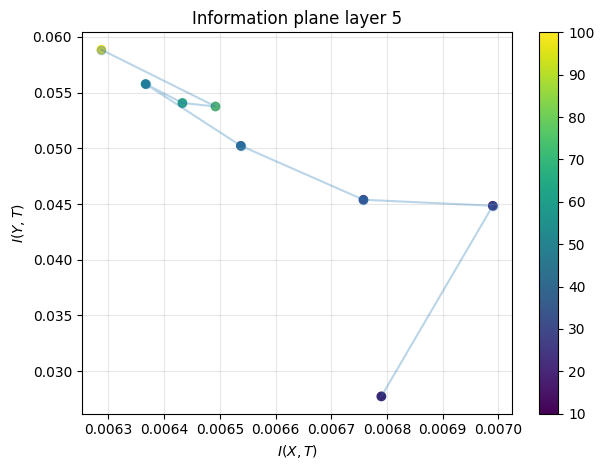

In [ ]:
EMIS_X = np.mean(i2l, axis = 1)
EMIS_Y = l2o

plt.scatter(EMIS_X, EMIS_Y, c = iters)
plt.plot(EMIS_X, EMIS_Y, '-o', alpha = 0.3)
plt.xlabel(r'$I(X,T)$')
plt.ylabel(r'$I(Y,T)$')
plt.title(f'Information plane layer 5')
plt.grid(alpha=0.3)
plt.colorbar()
plt.tight_layout()
plt.show()